# Self-Organizing Map (SOM)
A Self-Organizing Map (SOM), also known as a Kohonen Map (after Teuvo Kohonen who introduced it in the 1980s), is a type of unsupervised artificial neural network used for dimensionality reduction, clustering, and visualization of high-dimensional data.

Key Features of SOM:
Unsupervised Learning: SOM learns patterns from input data without labeled outputs.

Topology Preservation: It maps high-dimensional data into a low-dimensional (usually 2D or 3D) grid while preserving the topological structure (similar data points are close to each other).

Competitive Learning: Neurons (nodes) compete to best represent input data, and the winning neuron (Best Matching Unit, BMU) updates itself and its neighbors.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler

class SOM:
    def __init__(self, grid_size, input_dim, lr=0.3, sigma=1.0, max_iter=100):
        self.grid_size = grid_size  # (rows, cols)
        self.input_dim = input_dim
        self.lr = lr  # Initial learning rate
        self.sigma = sigma  # Initial neighborhood radius
        self.max_iter = max_iter
        
        # Initialize weights randomly
        self.weights = np.random.rand(grid_size[0], grid_size[1], input_dim)
    
    def _get_bmu(self, x):
        """Find the Best Matching Unit (BMU) for input x."""
        distances = np.linalg.norm(self.weights - x, axis=2)
        return np.unravel_index(np.argmin(distances), distances.shape)
    
    def _get_neighborhood(self, bmu, current_sigma):
        """Compute Gaussian neighborhood around BMU."""
        rows, cols = np.indices(self.grid_size)
        dist_sq = (rows - bmu[0])**2 + (cols - bmu[1])**2
        return np.exp(-dist_sq / (2 * current_sigma**2))
    
    def train(self, data):
        """Train the SOM on the given data."""
        for iter in range(self.max_iter):
            # Update learning rate and neighborhood radius
            t = iter / self.max_iter
            current_lr = self.lr * (1 - t)
            current_sigma = self.sigma * (1 - t)
            
            # Randomly select a sample
            x = data[np.random.choice(len(data))]
            
            # Find BMU
            bmu = self._get_bmu(x)
            
            # Update weights
            neighborhood = self._get_neighborhood(bmu, current_sigma)
            influence = current_lr * neighborhood[..., np.newaxis]
            self.weights += influence * (x - self.weights)
    
    def predict(self, data):
        """Assign each sample to its BMU."""
        return np.array([self._get_bmu(x) for x in data])
    
    def distance_map(self):
        """Generate U-Matrix for visualization."""
        umatrix = np.zeros(self.grid_size)
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                neighbors = []
                if i > 0: neighbors.append(self.weights[i-1, j])
                if i < self.grid_size[0]-1: neighbors.append(self.weights[i+1, j])
                if j > 0: neighbors.append(self.weights[i, j-1])
                if j < self.grid_size[1]-1: neighbors.append(self.weights[i, j+1])
                if neighbors:
                    umatrix[i, j] = np.mean(np.linalg.norm(self.weights[i, j] - np.array(neighbors), axis=1))
        return umatrix

## Synthetic Clustering (2D → 2D SOM)

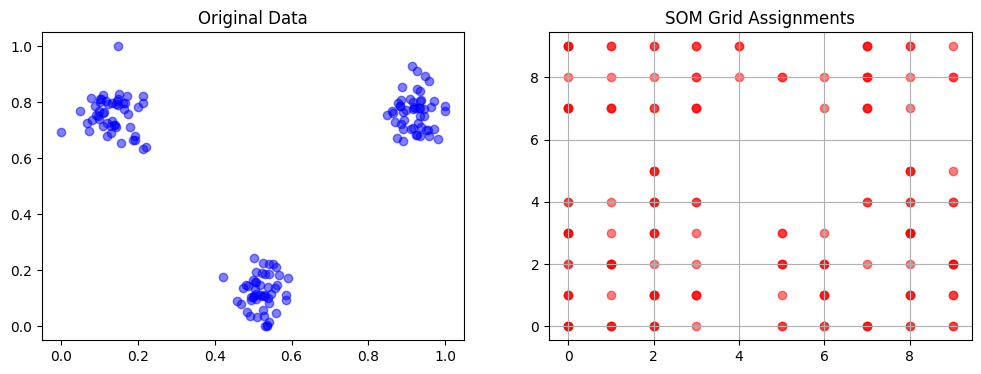

In [2]:
# Generate synthetic data (3 clusters)
np.random.seed(42)
cluster1 = np.random.normal(loc=[0, 0], scale=0.5, size=(50, 2))
cluster2 = np.random.normal(loc=[5, 5], scale=0.5, size=(50, 2))
cluster3 = np.random.normal(loc=[-5, 5], scale=0.5, size=(50, 2))
data = np.vstack([cluster1, cluster2, cluster3])

# Normalize data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Train SOM
som = SOM(grid_size=(10, 10), input_dim=2, lr=0.5, sigma=2.0, max_iter=1000)
som.train(data)

# Assign clusters
bmu_coords = som.predict(data)

# Visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], c='blue', alpha=0.5)
plt.title("Original Data")

plt.subplot(1, 2, 2)
plt.scatter(bmu_coords[:, 1], bmu_coords[:, 0], c='red', alpha=0.5)  # Note: (col, row) for grid
plt.title("SOM Grid Assignments")
plt.grid(True)
plt.show()

## IRIS Dataset (4D → 2D SOM)

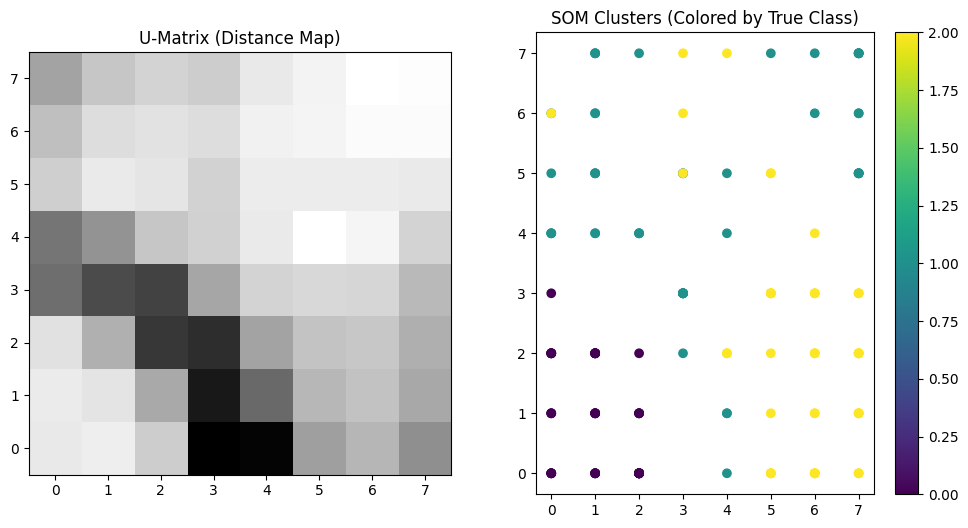

In [3]:
# Load IRIS data
iris = load_iris()
X = iris.data
y = iris.target

# Normalize
X = MinMaxScaler().fit_transform(X)

# Train SOM
som = SOM(grid_size=(8, 8), input_dim=4, lr=0.3, sigma=1.5, max_iter=500)
som.train(X)

# Assign BMUs
bmu_coords = som.predict(X)

# Visualize U-Matrix and clusters
umatrix = som.distance_map()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(umatrix, cmap='gray_r', origin='lower')
plt.title("U-Matrix (Distance Map)")

plt.subplot(1, 2, 2)
plt.scatter(bmu_coords[:, 1], bmu_coords[:, 0], c=y, cmap='viridis')
plt.title("SOM Clusters (Colored by True Class)")
plt.colorbar()
plt.show()